In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, TimeDistributed, Masking
from tensorflow.keras.optimizers import Adam
import h5py
import matplotlib.pyplot as plt
import numpy.ma as ma

In [2]:
from matplotlib.pyplot import figure
plt.rcParams["figure.figsize"] = (20,12)
figure(figsize=(100, 80), dpi=80)

<Figure size 8000x6400 with 0 Axes>

<Figure size 8000x6400 with 0 Axes>

In [3]:
tf.random.set_seed(12345)

In [4]:
# pip install -U numpy==1.18.5

In [5]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [6]:
with open('train_X_data.npy', 'rb') as f:
    train_X_data = np.load(f, allow_pickle=True)

In [7]:
with open('train_Y_data.npy', 'rb') as f:
    train_Y_data = np.load(f, allow_pickle=True)

In [8]:
with open('test_X_data.npy', 'rb') as f:
    test_X_data = np.load(f, allow_pickle=True)

In [9]:
with open('test_Y_data.npy', 'rb') as f:
    test_Y_data = np.load(f, allow_pickle=True)

In [10]:
f = h5py.File("plazamont_processed_data.h5","r")
scaled_X = ma.array(f["scaled_x"])
scaled_X.mask = ma.array(f["x_mask"])
minX = np.array(f["minX"])
maxX = np.array(f["maxX"])
f.close()

In [11]:
scaled_X

masked_array(
  data=[[0.1956745623069001],
        [0.1730175077239959],
        [0.1761071060762101],
        [0.15550978372811536],
        [0.16374871266735327],
        [0.16786817713697222],
        [0.14727085478887747],
        [0.14727085478887747],
        [0.22966014418125646],
        [0.15036045314109167],
        [0.13285272914521112],
        [0.141091658084449],
        [0.15550978372811536],
        [0.16168898043254376],
        [0.2008238928939238],
        [0.23789907312049433],
        [0.35015447991761073],
        [0.4335736354273944],
        [0.4696189495365602],
        [0.4984552008238929],
        [0.4830072090628218],
        [0.5417095777548918],
        [0.49433573635427397],
        [0.5036045314109165],
        [0.49742533470648814],
        [0.46446961894953653],
        [0.46446961894953653],
        [0.45417095777548916],
        [0.431513903192585],
        [0.42327497425334704],
        [0.35427394438722964],
        [0.3563336766220392],
        [

In [12]:
def inverse_scaler(scaled_x,minX,maxX):
    return scaled_x*maxX-minX

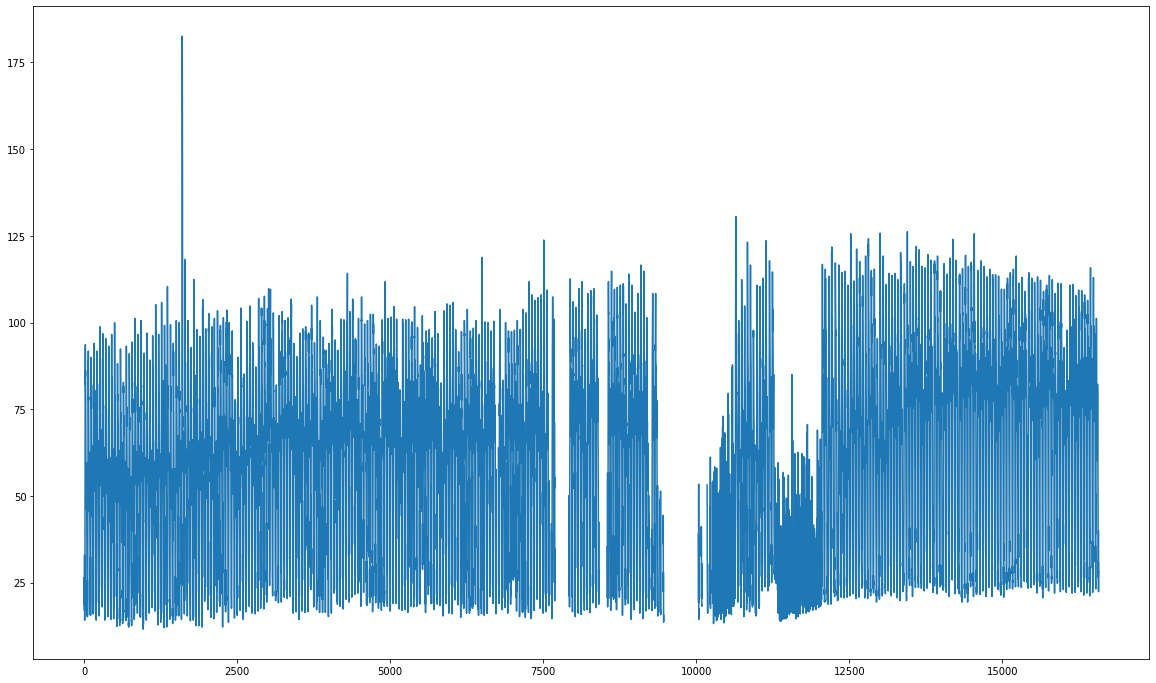

In [13]:
plt.plot(inverse_scaler(scaled_X,minX,maxX))
plt.show()

In [14]:
int(0.25*len(scaled_X))

4143

In [15]:
def partitionSet(test_fraction, data, partition):
    lenX = len(data)
    test_size = int(len(data) * test_fraction)
    test_df = data[int((partition/100)*lenX):int((partition/100)*lenX)+test_size]
    train_df = ma.vstack((data[:int((partition/100)*lenX)-1],data[int((partition/100)*lenX)+test_size:]))
    train_df[int((partition/100)*lenX)] = ma.masked
    return train_df, test_df

train_dataf = []
test_dataf = []

[train_df,test_df] = partitionSet(0.25,scaled_X, 16)

In [16]:
timesteps = 24

In [17]:
X_train = ma.array([train_df[t:t+timesteps] for t in range(0, len(train_df)-timesteps)])
y_train = train_df[timesteps:, :]
X_test = ma.array([test_df[t:t+timesteps] for t in range(0, len(test_df)-timesteps)]) 
y_test = test_df[timesteps:, :]

In [19]:
def LSTM_function(NCells, timesteps, num_features, dropout, NBEpochs, Batchsize, validationSplit):
    model = Sequential()
    model.add(Masking(mask_value=0., input_shape=(timesteps, num_features)))
    model.add(LSTM(1, activation = 'tanh', input_shape = (timesteps, num_features), return_sequences=True))
    model.add(Dropout(dropout))
    model.add(LSTM(NCells))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    opt = Adam(learning_rate=0.0002)
    model.compile(loss = 'mse', optimizer=opt)
    X_ = ma.filled(X_train,0)
    Y_ = ma.filled(y_train,0)
    MODEL = model.fit(X_, Y_, epochs = NBEpochs, batch_size = Batchsize,
                      validation_split = validationSplit, shuffle = False)
    return model, MODEL

In [20]:
model, MODEL = LSTM_function(32, X_train.shape[1], 1, 0.15, 200, 256, 0.2)

Epoch 1/200
39/39 [==============================] - 9s 75ms/step - loss: 0.0862 - val_loss: 0.0977
Epoch 2/200
39/39 [==============================] - 1s 28ms/step - loss: 0.0340 - val_loss: 0.0319
Epoch 3/200
39/39 [==============================] - 1s 30ms/step - loss: 0.0223 - val_loss: 0.0301
Epoch 4/200
39/39 [==============================] - 1s 29ms/step - loss: 0.0224 - val_loss: 0.0300
Epoch 5/200
39/39 [==============================] - 1s 28ms/step - loss: 0.0221 - val_loss: 0.0302
Epoch 6/200
39/39 [==============================] - 1s 30ms/step - loss: 0.0223 - val_loss: 0.0301
Epoch 7/200
39/39 [==============================] - 1s 32ms/step - loss: 0.0222 - val_loss: 0.0300
Epoch 8/200
39/39 [==============================] - 1s 30ms/step - loss: 0.0219 - val_loss: 0.0300
Epoch 9/200
39/39 [==============================] - 1s 30ms/step - loss: 0.0220 - val_loss: 0.0300
Epoch 10/200
39/39 [==============================] - 1s 28ms/step - loss: 0.0219 - val_loss: 0.0298

39/39 [==============================] - 1s 29ms/step - loss: 0.0074 - val_loss: 0.0064
Epoch 163/200
39/39 [==============================] - 1s 29ms/step - loss: 0.0073 - val_loss: 0.0065
Epoch 164/200
39/39 [==============================] - 1s 29ms/step - loss: 0.0074 - val_loss: 0.0063
Epoch 165/200
39/39 [==============================] - 1s 29ms/step - loss: 0.0073 - val_loss: 0.0062
Epoch 166/200
39/39 [==============================] - 1s 33ms/step - loss: 0.0073 - val_loss: 0.0063
Epoch 167/200
39/39 [==============================] - 1s 32ms/step - loss: 0.0072 - val_loss: 0.0064
Epoch 168/200
39/39 [==============================] - 1s 32ms/step - loss: 0.0072 - val_loss: 0.0060
Epoch 169/200
39/39 [==============================] - 1s 32ms/step - loss: 0.0073 - val_loss: 0.0061
Epoch 170/200
39/39 [==============================] - 1s 32ms/step - loss: 0.0071 - val_loss: 0.0061
Epoch 171/200
39/39 [==============================] - 1s 32ms/step - loss: 0.0072 - val_loss: 0

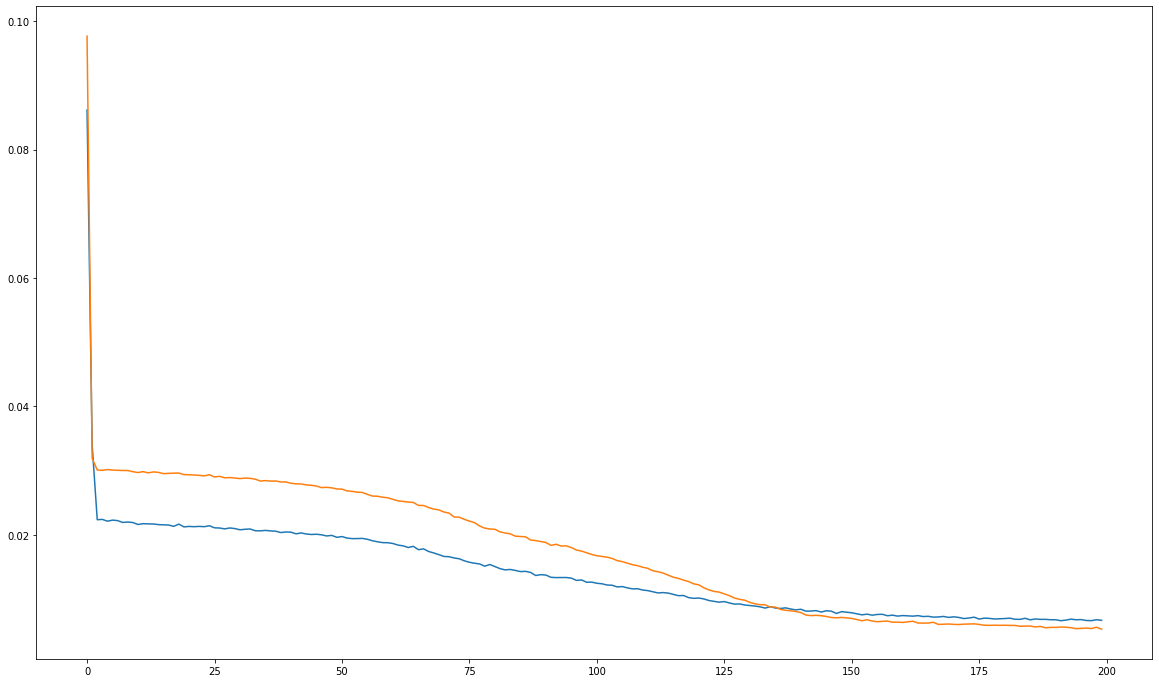

In [21]:
plt.plot(MODEL.history['loss'])
plt.plot(MODEL.history['val_loss'])
plt.show()

In [22]:
X_test.shape

(4119, 24, 1)

In [23]:
prediction_test = model.predict(X_test)

In [24]:
prediction_train = model.predict(X_train)

In [25]:
test_pred = ma.masked_invalid(prediction_test)

In [26]:
test_pred[np.where(ma.array(y_test[:,0]==ma.masked))[0],:] = ma.masked

In [27]:
test_pred.shape

(4119, 1)

In [28]:
train_pred = ma.masked_invalid(prediction_train)

In [35]:
train_pred[[np.where(y_train[:,0]==ma.masked)[0]],:] = ma.masked

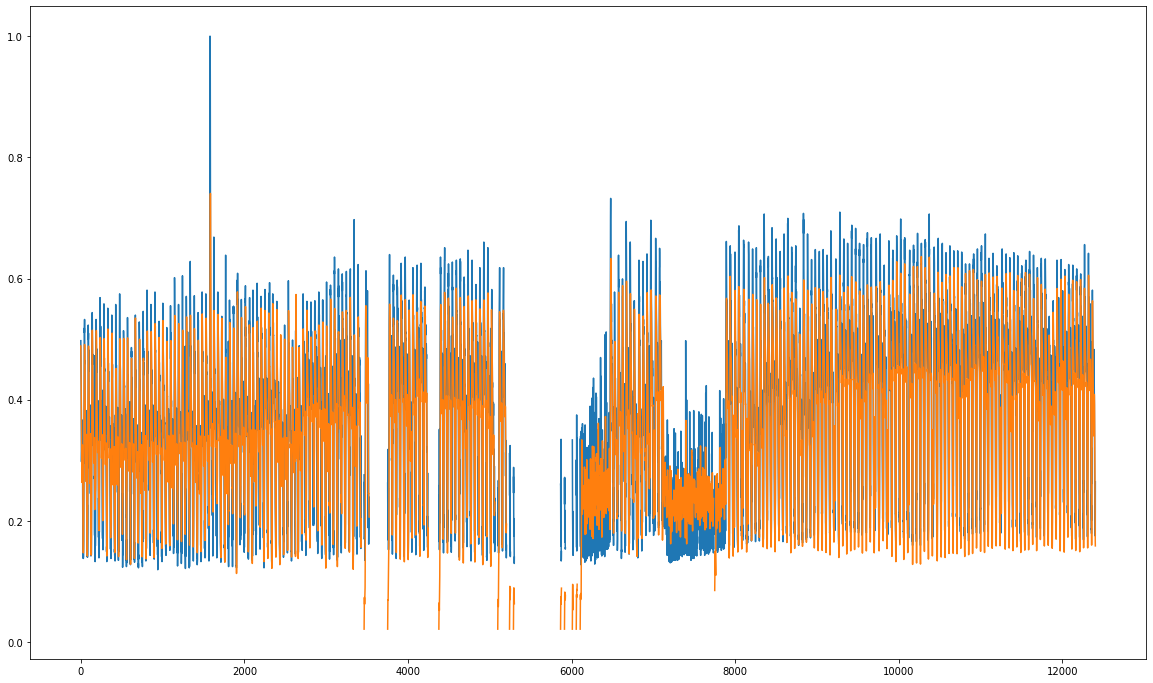

In [36]:
plt.plot(y_train[:,0])
plt.plot(train_pred[:,0])
plt.show()

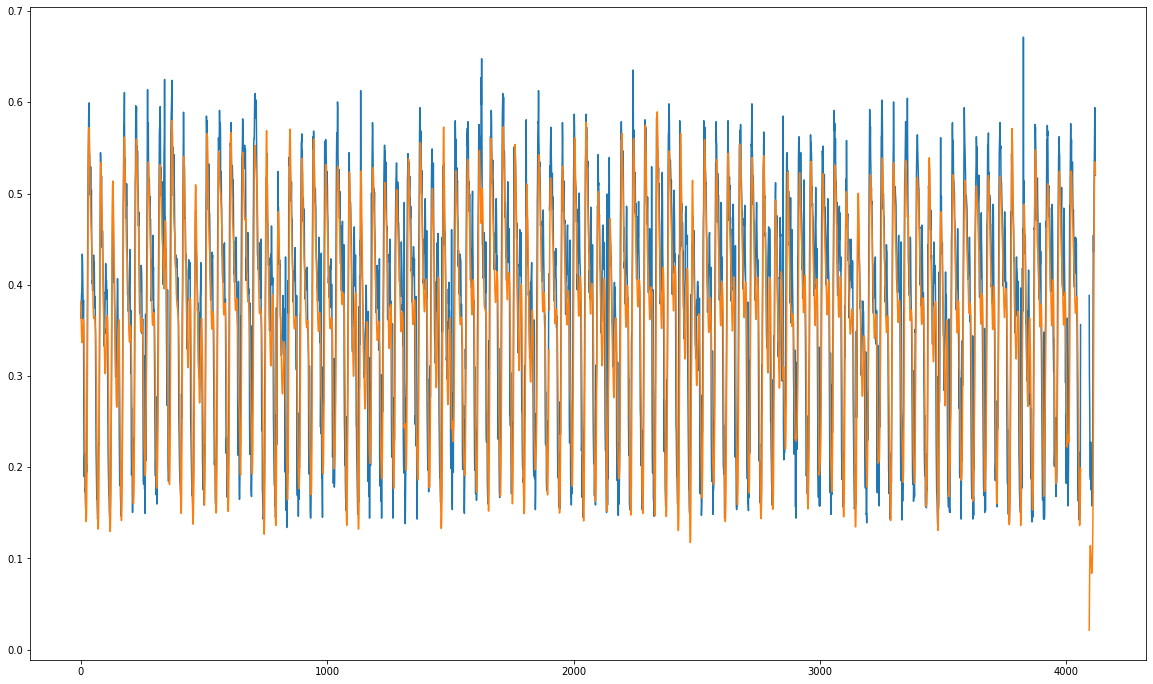

In [37]:
plt.plot(y_test[:,0])
plt.plot(test_pred[:,0])
plt.show()

In [38]:
inputs = scaled_X[len(scaled_X) - len(test_df) - timesteps:]

In [39]:
inputs

masked_array(
  data=[[0.286302780638517],
        [0.26158599382080333],
        [0.23892893923789907],
        [0.22554067971163752],
        [0.19876416065911434],
        [0.19361483007209065],
        [0.19464469618949537],
        [0.19258496395468588],
        [0.18640576725025748],
        [0.19464469618949537],
        [0.16889804325437693],
        [0.16580844490216273],
        [0.18640576725025748],
        [0.19670442842430486],
        [0.18331616889804328],
        [0.19052523171987643],
        [0.23789907312049435],
        [0.31204943357363546],
        [0.36972193614830073],
        [0.446961894953656],
        [0.5324407826982492],
        [0.650875386199794],
        [0.6014418125643667],
        [0.6096807415036045],
        [0.576725025746653],
        [0.5674562306900103],
        [0.5221421215242018],
        [0.5036045314109165],
        [0.4747682801235839],
        [0.4479917610710608],
        [0.4479917610710608],
        [0.4747682801235839],
        [0.4

In [40]:
inputs = inputs.reshape(-1,1)

In [41]:
X_test = []

In [42]:
for i in range(24, 360):
    X_test.append(inputs[i-timesteps:i,0])

In [43]:
X_test = np.array(X_test)

In [44]:
X_test.shape

(336, 24)

In [45]:
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [46]:
predicted_demand = model.predict(X_test)

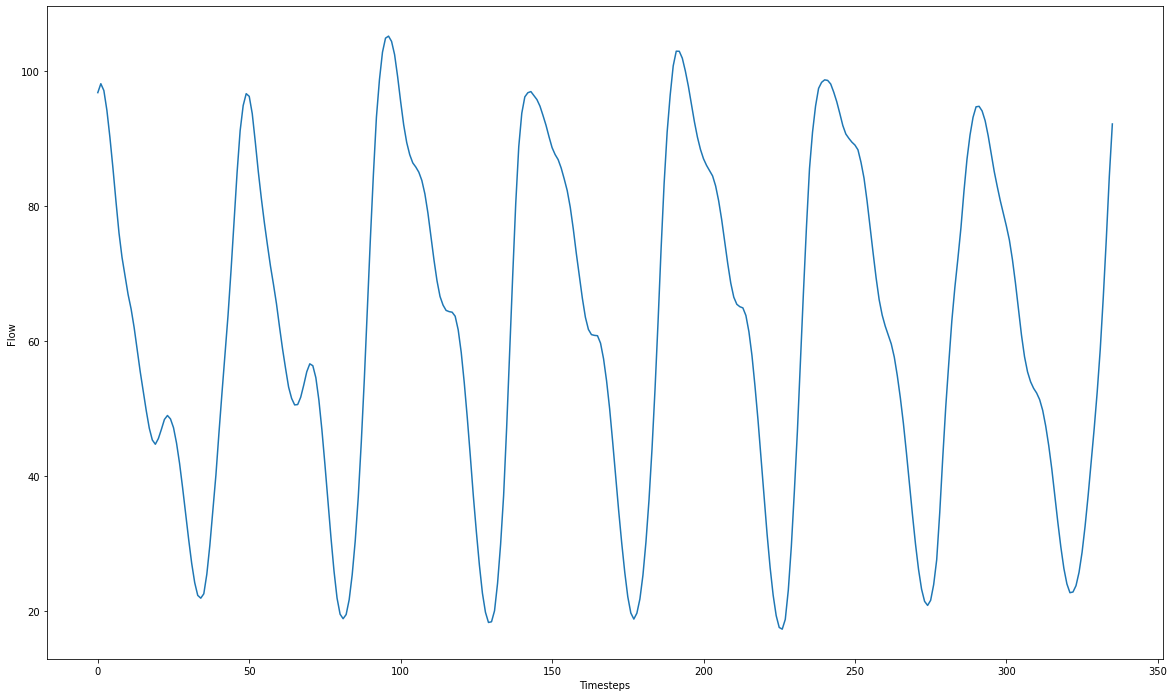

In [47]:
plt.plot(inverse_scaler(predicted_demand, minX, maxX))
plt.xlabel('Timesteps')
plt.ylabel('Flow')
plt.savefig('prediction.jpg')